In [1]:
import os
from pathlib import Path
from fastai import *
from fastai.vision import *

In [2]:
path = Path(os.getenv("HOME")+"/.fastai/data/oxford-iiit-pet")

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [4]:
if False:
    """
    I manually downloaded and extracted the data with
    ```
    mkdir -p ~/.fastai/data
    cd ~/.fastai/data
    wget -c https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz
    tar -zxvf oxford-iiit-pet.tgz
    ```
    """
    PETS_URL = "https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet"
    path = untar_data(PETS_URL)

In [5]:
path.ls()

[PosixPath('/home/jayme/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jayme/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/"annotations"
path_img = path/"images"

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jayme/.fastai/data/oxford-iiit-pet/images/havanese_100.jpg'),
 PosixPath('/home/jayme/.fastai/data/oxford-iiit-pet/images/american_bulldog_132.jpg'),
 PosixPath('/home/jayme/.fastai/data/oxford-iiit-pet/images/english_setter_82.jpg'),
 PosixPath('/home/jayme/.fastai/data/oxford-iiit-pet/images/great_pyrenees_161.jpg'),
 PosixPath('/home/jayme/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_41.jpg')]

In [8]:
pat = r"/([^/]+)_\d+.jpg$"

In [9]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
havanese,american_bulldog,english_setter,great_pyrenees,wheaten_terrier
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
havanese,german_shorthaired,english_cocker_spaniel,german_shorthaired,Bombay
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Test: None

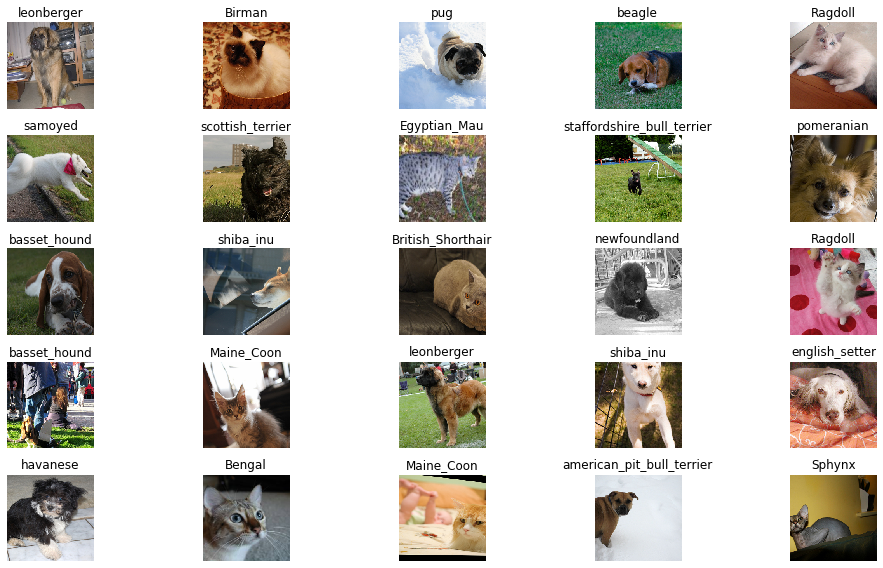

In [10]:
data.show_batch(row=3, figsize=(14, 8))

In [11]:
print(data.classes)
len(data.classes), data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

# training resnet34

Now we will transfer learn using a pre trained a convolutional neural network called ResNet34 and fine tune it to output the probability of each one of the 37 classes we are dealing with

In [12]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/home/jayme/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [13]:
try:
    learn.load("stage-1")
except:
    learn.fit_one_cycle(4)
    learn.save("stage-1")

# results

Now we will interpret the results, seeing some predictions, plotting the confusion matrix

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

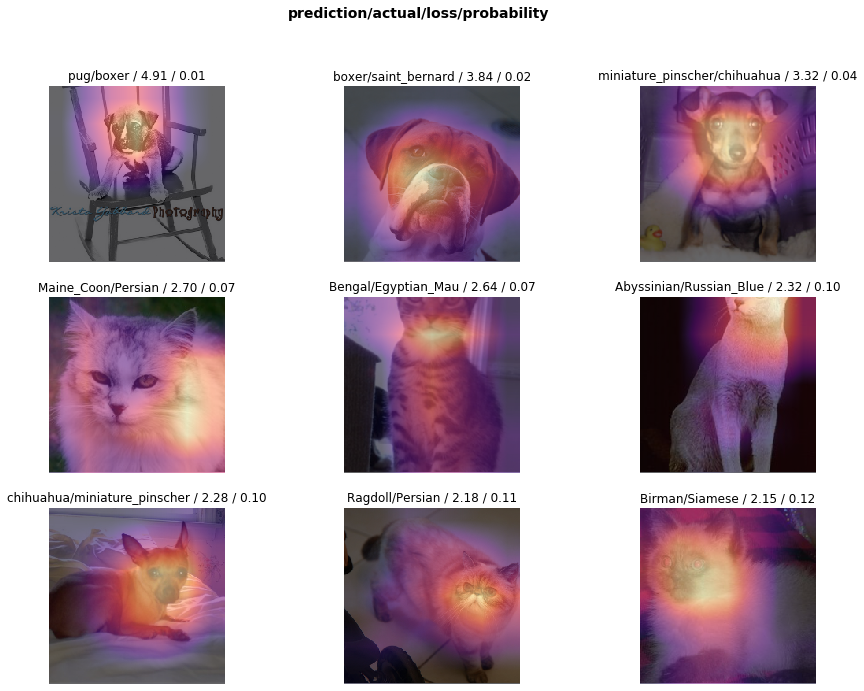

In [15]:
interp.plot_top_losses(k=9, figsize=(15, 11))

In [16]:
doc(interp.plot_top_losses)

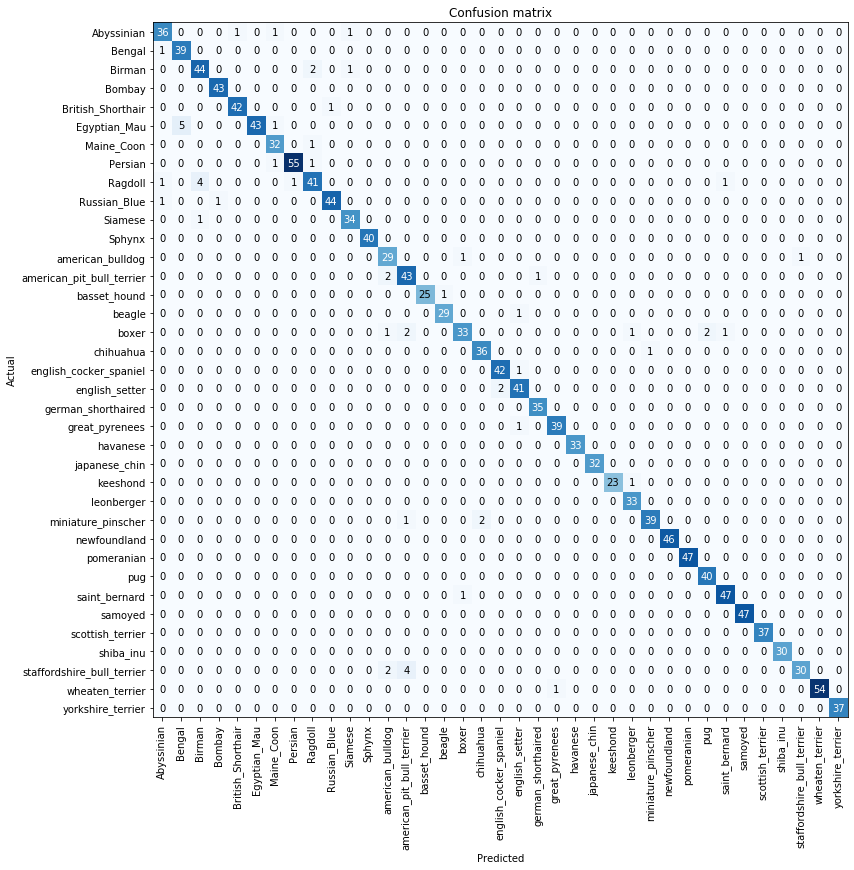

In [17]:
interp.plot_confusion_matrix(figsize=(12, 12))

In [18]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Birman', 'Ragdoll', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('boxer', 'pug', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

# unfreezing, fine tuning and learning rate


When the define the learner (create_cnn), we only fit the last layer (the original ResNet layers are left untouched).


By calling "unfreeze", we start changing all the model's layers/parameters at the same speed, including the ResNet architecture and out final layer

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.492001,0.308353,0.098782,00:43


In [22]:
learn.load("stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
havanese,american_bulldog,english_setter,great_pyrenees,wheaten_terrier
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
havanese,german_shorthaired,english_cocker_spaniel,german_shorthaired,Bombay
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1):

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


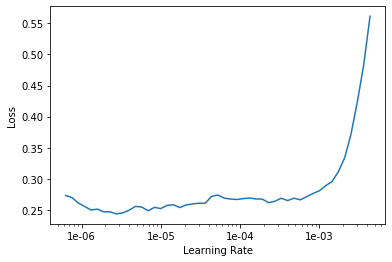

In [24]:
learn.recorder.plot()

In [26]:
# unfreeze the entire model
# train the first layers at a learning rate of 1e-6
# train the last layers at 1e-4
# distribute all the other layers in between those values
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.249207,0.117353,0.037889,00:48
1,0.226893,0.118802,0.037212,00:47


# fitting ResNet50

In [27]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=32)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
havanese,american_bulldog,english_setter,great_pyrenees,wheaten_terrier
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
yorkshire_terrier,Ragdoll,german_shorthaired,Ragdoll,pomeranian
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Test: None

In [28]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/home/jayme/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jayme/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:54<00:00, 1874611.70it/s]


In [29]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.673599,0.247337,0.078484,01:14
1,0.432761,0.247713,0.082544,01:10
2,0.293679,0.183965,0.067659,01:09
3,0.197883,0.159787,0.054127,01:10
4,0.138796,0.156389,0.055480,01:11


In [30]:
learn.save("lesson1-resnet50")

In [33]:
learn.load("lesson1-resnet50")

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
havanese,american_bulldog,english_setter,great_pyrenees,wheaten_terrier
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
yorkshire_terrier,Ragdoll,german_shorthaired,Ragdoll,pomeranian
Path: /home/jayme/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 6

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

In [36]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('beagle', 'basset_hound', 4),
 ('Birman', 'Ragdoll', 3),
 ('Ragdoll', 'Birman', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'British_Shorthair', 2),
 ('Bengal', 'Egyptian_Mau', 2),
 ('Birman', 'Siamese', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'havanese', 2),
 ('great_pyrenees', 'beagle', 2),
 ('miniature_pinscher', 'chihuahua', 2)]